# Per-Layer Energy Profiling for GPT-2
## ESE 5390 Final Project: Layer-wise Energy Analysis

This notebook analyzes the energy consumption of each layer in GPT-2 Small (FP32 baseline).

**Goal**: Identify which layers consume the most energy to guide selective quantization strategies.

**Approach**:
1. Use PyTorch hooks to measure execution time per layer
2. Monitor GPU power during inference
3. Compute energy consumption per layer
4. Visualize energy hotspots in the model

## 1. Setup and Imports

In [1]:
!git clone https://github.com/krishkc5/energy_aware_quantization

Cloning into 'energy_aware_quantization'...
remote: Enumerating objects: 416, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 416 (delta 110), reused 118 (delta 68), pack-reused 238 (from 1)
Receiving objects: 100% (416/416), 4.03 MiB | 18.19 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [2]:
import torch
import torch.nn as nn
from transformers import GPT2LMHeadModel
import numpy as np
import pandas as pd
import json
import time
import subprocess
import threading
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Force GPU usage
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    raise RuntimeError("GPU not available! This notebook requires CUDA.")
print(f"\n✓ Using device: {device}")

2025-12-04 04:34:11.910958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764822852.117461      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764822852.177258      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA device: Tesla T4
CUDA version: 12.4

✓ Using device: cuda


## 2. Load GPT-2 Tokenized Dataset

In [3]:
import os

cwd = os.getcwd()
print(f"Current working directory: {cwd}")

# Search for tokenized dataset
possible_paths = [
    Path(cwd) / ".." / "datasets" / "gpt2_tokenized_data",
    Path(cwd) / "datasets" / "gpt2_tokenized_data",
    Path(cwd) / "energy_aware_quantization" / "datasets" / "gpt2_tokenized_data",
    Path("/kaggle/working/gpt2_tokenized_data"),
]

dataset_path = None
for path in possible_paths:
    if path.exists() and (path / "input_ids.pt").exists():
        dataset_path = path
        break

if dataset_path is None:
    current = Path(cwd)
    for _ in range(5):
        test_path = current / "datasets" / "gpt2_tokenized_data"
        if test_path.exists() and (test_path / "input_ids.pt").exists():
            dataset_path = test_path
            break
        current = current.parent

if dataset_path is None:
    raise FileNotFoundError("Could not find GPT-2 tokenized dataset. Please run gpt2_tokenized_dataset.ipynb first.")

print(f"\n✓ Found dataset at: {dataset_path}")

# Load dataset - ALL ON GPU
input_ids = torch.load(dataset_path / "input_ids.pt", map_location=device)
attention_mask = torch.load(dataset_path / "attention_mask.pt", map_location=device)
labels = torch.load(dataset_path / "labels.pt", map_location=device)

print(f"\n✓ Loaded dataset:")
print(f"  - Samples: {input_ids.shape[0]}")
print(f"  - Sequence length: {input_ids.shape[1]}")
print(f"  - Device: {input_ids.device}")
print(f"  - Memory: {input_ids.element_size() * input_ids.nelement() / 1024**2:.2f} MB")

Current working directory: /kaggle/working

✓ Found dataset at: /kaggle/working/energy_aware_quantization/datasets/gpt2_tokenized_data

✓ Loaded dataset:
  - Samples: 1940
  - Sequence length: 128
  - Device: cuda:0
  - Memory: 1.89 MB


## 3. Load GPT-2 Model (FP32)

In [4]:
model_name = "gpt2"

print(f"Loading {model_name}...")
model = GPT2LMHeadModel.from_pretrained(
    model_name,
    torch_dtype=torch.float32  # Explicitly FP32
)
model = model.to(device)
model.eval()

print(f"\n✓ Model loaded")
print(f"  - Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  - Device: {next(model.parameters()).device}")
print(f"  - Dtype: {next(model.parameters()).dtype}")

# Print model architecture
print(f"\n📋 Model Architecture:")
for name, module in model.named_children():
    print(f"  - {name}: {module.__class__.__name__}")

Loading gpt2...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


✓ Model loaded
  - Parameters: 124,439,808
  - Device: cuda:0
  - Dtype: torch.float32

📋 Model Architecture:
  - transformer: GPT2Model
  - lm_head: Linear


## 4. Layer Type Helper Function

In [5]:
# Extract layer type from name
def get_layer_type(name: str) -> str:
    """Extract layer type from full layer name."""
    if "attn.c_attn" in name:
        return "Attention QKV Projection"
    elif "attn.c_proj" in name:
        return "Attention Output"
    elif "mlp.c_fc" in name:
        return "MLP Layer 1 (Expansion)"
    elif "mlp.c_proj" in name:
        return "MLP Layer 2 (Projection)"
    elif "ln_" in name:
        return "LayerNorm"
    elif "wte" in name or "wpe" in name:
        return "Embeddings"
    elif "lm_head" in name:
        return "LM Head"
    elif "dropout" in name:
        return "Dropout"
    else:
        return "Other"

print("✓ Helper function defined")

✓ Helper function defined


## 5. Layer Profiler with Timing Hooks

We'll use PyTorch forward hooks to measure execution time for each layer.

In [6]:
class LayerProfiler:
    """
    Profile execution time of each layer using forward hooks.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_times = defaultdict(list)
        self.layer_names = []
        
        # Register hooks for all named modules
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward pre/post hooks on all layers."""
        
        def make_pre_hook(name):
            def pre_hook(module, input):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_start"].append(time.perf_counter())
            return pre_hook
        
        def make_post_hook(name):
            def post_hook(module, input, output):
                if self.device == "cuda":
                    torch.cuda.synchronize()
                self.layer_times[name + "_end"].append(time.perf_counter())
            return post_hook
        
        # Register hooks on important layers (leaf modules only)
        for name, module in self.model.named_modules():
            # Skip container modules and focus on actual computation layers
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding, nn.Conv1d)):
                    self.layer_names.append(name)
                    hook_pre = module.register_forward_pre_hook(make_pre_hook(name))
                    hook_post = module.register_forward_hook(make_post_hook(name))
                    self.hooks.append(hook_pre)
                    self.hooks.append(hook_post)
        
        print(f"✓ Registered hooks on {len(self.layer_names)} layers")
    
    def reset(self):
        """Reset timing statistics."""
        self.layer_times.clear()
    
    def remove_hooks(self):
        """Remove all hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
    
    def get_layer_times(self) -> Dict[str, float]:
        """
        Compute average execution time per layer.
        
        Returns:
            Dictionary mapping layer name to average time in seconds
        """
        layer_avg_times = {}
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                layer_avg_times[name] = np.mean(durations)
        
        return layer_avg_times
    
    def get_layer_stats(self) -> pd.DataFrame:
        """
        Get detailed statistics for each layer.
        
        Returns:
            DataFrame with layer statistics
        """
        stats = []
        
        for name in self.layer_names:
            start_times = self.layer_times.get(name + "_start", [])
            end_times = self.layer_times.get(name + "_end", [])
            
            if len(start_times) == len(end_times) and len(start_times) > 0:
                durations = [end - start for start, end in zip(start_times, end_times)]
                
                stats.append({
                    "layer_name": name,
                    "mean_time_ms": np.mean(durations) * 1000,
                    "std_time_ms": np.std(durations) * 1000,
                    "min_time_ms": np.min(durations) * 1000,
                    "max_time_ms": np.max(durations) * 1000,
                    "total_time_s": np.sum(durations),
                    "num_calls": len(durations)
                })
        
        df = pd.DataFrame(stats)
        
        # Add percentage of total time
        if len(df) > 0:
            total_time = df["total_time_s"].sum()
            df["percent_total"] = (df["total_time_s"] / total_time) * 100
        
        return df.sort_values("total_time_s", ascending=False)


# Create profiler
profiler = LayerProfiler(model, device=device)

✓ Registered hooks on 65 layers


## 6. Power Monitor

Simple power monitoring using nvidia-smi.

In [7]:
class SimplePowerMonitor:
    """
    Simple power monitor using nvidia-smi.
    """
    
    def __init__(self, interval_ms: int = 50, gpu_id: int = 0):
        self.interval_ms = interval_ms
        self.gpu_id = gpu_id
        self.samples = []
        self.is_running = False
        self._thread = None
        self._lock = threading.Lock()
    
    def _poll(self):
        """Poll nvidia-smi for power readings."""
        interval_sec = self.interval_ms / 1000.0
        
        while self.is_running:
            try:
                result = subprocess.run(
                    ["nvidia-smi", "--query-gpu=power.draw", "--format=csv,noheader,nounits", f"--id={self.gpu_id}"],
                    capture_output=True, text=True, timeout=2
                )
                if result.returncode == 0:
                    power = float(result.stdout.strip().split('\n')[0].strip())
                    with self._lock:
                        self.samples.append((time.perf_counter(), power))
            except:
                pass
            time.sleep(interval_sec)
    
    def start(self):
        """Start monitoring."""
        with self._lock:
            self.samples = []
            self.is_running = True
        
        self._thread = threading.Thread(target=self._poll, daemon=True)
        self._thread.start()
    
    def stop(self):
        """Stop monitoring."""
        self.is_running = False
        if self._thread:
            self._thread.join(timeout=2)
    
    def get_samples(self) -> List[Tuple[float, float]]:
        """Get (timestamp, power) samples."""
        with self._lock:
            return self.samples.copy()
    
    def get_mean_power(self) -> float:
        """Get mean power in Watts."""
        samples = self.get_samples()
        if len(samples) == 0:
            return 0.0
        return np.mean([p for _, p in samples])


power_monitor = SimplePowerMonitor(interval_ms=50)
print("✓ Power monitor initialized")

✓ Power monitor initialized


## 7. Run Profiling Inference

Run inference with layer profiling and power monitoring.

In [8]:
# Warmup
print("Warming up GPU...")
with torch.no_grad():
    for i in range(20):
        idx = i % input_ids.shape[0]
        _ = model(input_ids=input_ids[idx].unsqueeze(0), attention_mask=attention_mask[idx].unsqueeze(0))
torch.cuda.synchronize()
print("✓ Warmup complete\n")

# Reset profiler
profiler.reset()

# Run profiling with power monitoring
num_iters = 100
print(f"Running {num_iters} profiling iterations...")

power_monitor.start()
time.sleep(0.5)  # Let power monitor stabilize

torch.cuda.synchronize()
start_time = time.perf_counter()

with torch.no_grad():
    for i in range(num_iters):
        idx = i % input_ids.shape[0]
        _ = model(
            input_ids=input_ids[idx].unsqueeze(0),
            attention_mask=attention_mask[idx].unsqueeze(0)
        )
        
        if (i + 1) % 20 == 0:
            print(f"  Progress: {i+1}/{num_iters}", end='\r')

torch.cuda.synchronize()
end_time = time.perf_counter()

time.sleep(0.5)  # Capture trailing power samples
power_monitor.stop()

total_time = end_time - start_time
mean_power = power_monitor.get_mean_power()

print(f"\n\n✓ Profiling complete")
print(f"  - Total time: {total_time:.3f}s")
print(f"  - Mean power: {mean_power:.2f}W")
print(f"  - Total energy: {mean_power * total_time:.3f}J")
print(f"  - Power samples: {len(power_monitor.get_samples())}")

Warming up GPU...
✓ Warmup complete

Running 100 profiling iterations...
  Progress: 100/100

✓ Profiling complete
  - Total time: 1.497s
  - Mean power: 54.14W
  - Total energy: 81.026J
  - Power samples: 33


## 8. Analyze Per-Layer Timing

In [9]:
# Get layer statistics
layer_stats = profiler.get_layer_stats()

print("\n" + "="*80)
print("PER-LAYER TIMING STATISTICS (Top 20)")
print("="*80)
print(layer_stats.head(20).to_string(index=False))
print("="*80)

# Save to CSV
output_dir = Path("../results")
output_dir.mkdir(parents=True, exist_ok=True)
layer_stats.to_csv(output_dir / "per_layer_timing_gpt2_fp32.csv", index=False)
print(f"\n✓ Saved layer timing to: {output_dir / 'per_layer_timing_gpt2_fp32.csv'}")


PER-LAYER TIMING STATISTICS (Top 20)
           layer_name  mean_time_ms  std_time_ms  min_time_ms  max_time_ms  total_time_s  num_calls  percent_total
              lm_head      1.722814     0.017922     1.677988     1.758372      0.172281        100      46.024205
      transformer.wte      0.072871     0.036211     0.056328     0.318363      0.007287        100       1.946708
 transformer.h.0.ln_1      0.059940     0.015678     0.049680     0.121812      0.005994        100       1.601269
 transformer.h.9.ln_1      0.056186     0.022984     0.045180     0.225911      0.005619        100       1.500994
transformer.h.10.ln_1      0.055703     0.018076     0.044908     0.170299      0.005570        100       1.488084
 transformer.h.0.ln_2      0.054529     0.024442     0.043633     0.258364      0.005453        100       1.456717
 transformer.h.7.ln_1      0.053976     0.013168     0.044902     0.102876      0.005398        100       1.441944
 transformer.h.2.ln_2      0.053541     0.

## 9. Compute Per-Layer Energy Consumption

Estimate energy per layer using:
- Layer execution time (from profiling)
- Mean GPU power (from power monitor)

**Energy per layer = (Layer time / Total time) × Total energy**

In [10]:
# Compute per-layer energy
total_energy = mean_power * total_time  # Joules
total_measured_time = layer_stats["total_time_s"].sum()

layer_stats["energy_j"] = (layer_stats["total_time_s"] / total_measured_time) * total_energy
layer_stats["energy_mj"] = layer_stats["energy_j"] * 1000
layer_stats["energy_per_call_mj"] = layer_stats["energy_mj"] / layer_stats["num_calls"]

# Sort by energy consumption
layer_stats = layer_stats.sort_values("energy_j", ascending=False)

print("\n" + "="*100)
print("PER-LAYER ENERGY CONSUMPTION (Top 20)")
print("="*100)
print(layer_stats[["layer_name", "mean_time_ms", "energy_mj", "energy_per_call_mj", "percent_total"]].head(20).to_string(index=False))
print("="*100)

# Save to CSV
layer_stats.to_csv(output_dir / "per_layer_energy_gpt2_fp32.csv", index=False)
print(f"\n✓ Saved layer energy to: {output_dir / 'per_layer_energy_gpt2_fp32.csv'}")


PER-LAYER ENERGY CONSUMPTION (Top 20)
           layer_name  mean_time_ms    energy_mj  energy_per_call_mj  percent_total
              lm_head      1.722814 37291.708938          372.917089      46.024205
      transformer.wte      0.072871  1577.345057           15.773451       1.946708
 transformer.h.0.ln_1      0.059940  1297.449298           12.974493       1.601269
 transformer.h.9.ln_1      0.056186  1216.199566           12.161996       1.500994
transformer.h.10.ln_1      0.055703  1205.739659           12.057397       1.488084
 transformer.h.0.ln_2      0.054529  1180.324008           11.803240       1.456717
 transformer.h.7.ln_1      0.053976  1168.353439           11.683534       1.441944
 transformer.h.2.ln_2      0.053541  1158.944437           11.589444       1.430331
transformer.h.11.ln_1      0.053265  1152.962615           11.529626       1.422949
 transformer.h.1.ln_2      0.052443  1135.163694           11.351637       1.400982
 transformer.h.3.ln_1      0.052432  

## 10. Group Energy by Layer Type

In [11]:
layer_stats["layer_type"] = layer_stats["layer_name"].apply(get_layer_type)

# Group by layer type
type_energy = layer_stats.groupby("layer_type").agg({
    "energy_j": "sum",
    "energy_mj": "sum",
    "total_time_s": "sum",
    "layer_name": "count"
}).rename(columns={"layer_name": "num_layers"})

type_energy["percent_energy"] = (type_energy["energy_j"] / type_energy["energy_j"].sum()) * 100
type_energy = type_energy.sort_values("energy_j", ascending=False)

print("\n" + "="*80)
print("ENERGY CONSUMPTION BY LAYER TYPE")
print("="*80)
print(type_energy.to_string())
print("="*80)

# Save to CSV
type_energy.to_csv(output_dir / "energy_by_layer_type_gpt2_fp32.csv")
print(f"\n✓ Saved grouped energy to: {output_dir / 'energy_by_layer_type_gpt2_fp32.csv'}")


ENERGY CONSUMPTION BY LAYER TYPE
             energy_j     energy_mj  total_time_s  num_layers  percent_energy
layer_type                                                                   
LM Head     37.291709  37291.708938      0.172281           1       46.024205
LayerNorm   28.408845  28408.844537      0.131244          25       35.061265
Dropout     12.192016  12192.015592      0.056325          24       15.046986
Embeddings   2.585292   2585.291750      0.011944           2        3.190682
Other        0.548436    548.436124      0.002534           1        0.676862

✓ Saved grouped energy to: ../results/energy_by_layer_type_gpt2_fp32.csv


## 11. Visualizations


✓ Saved plots to: ../results/per_layer_energy_analysis_gpt2_fp32.png


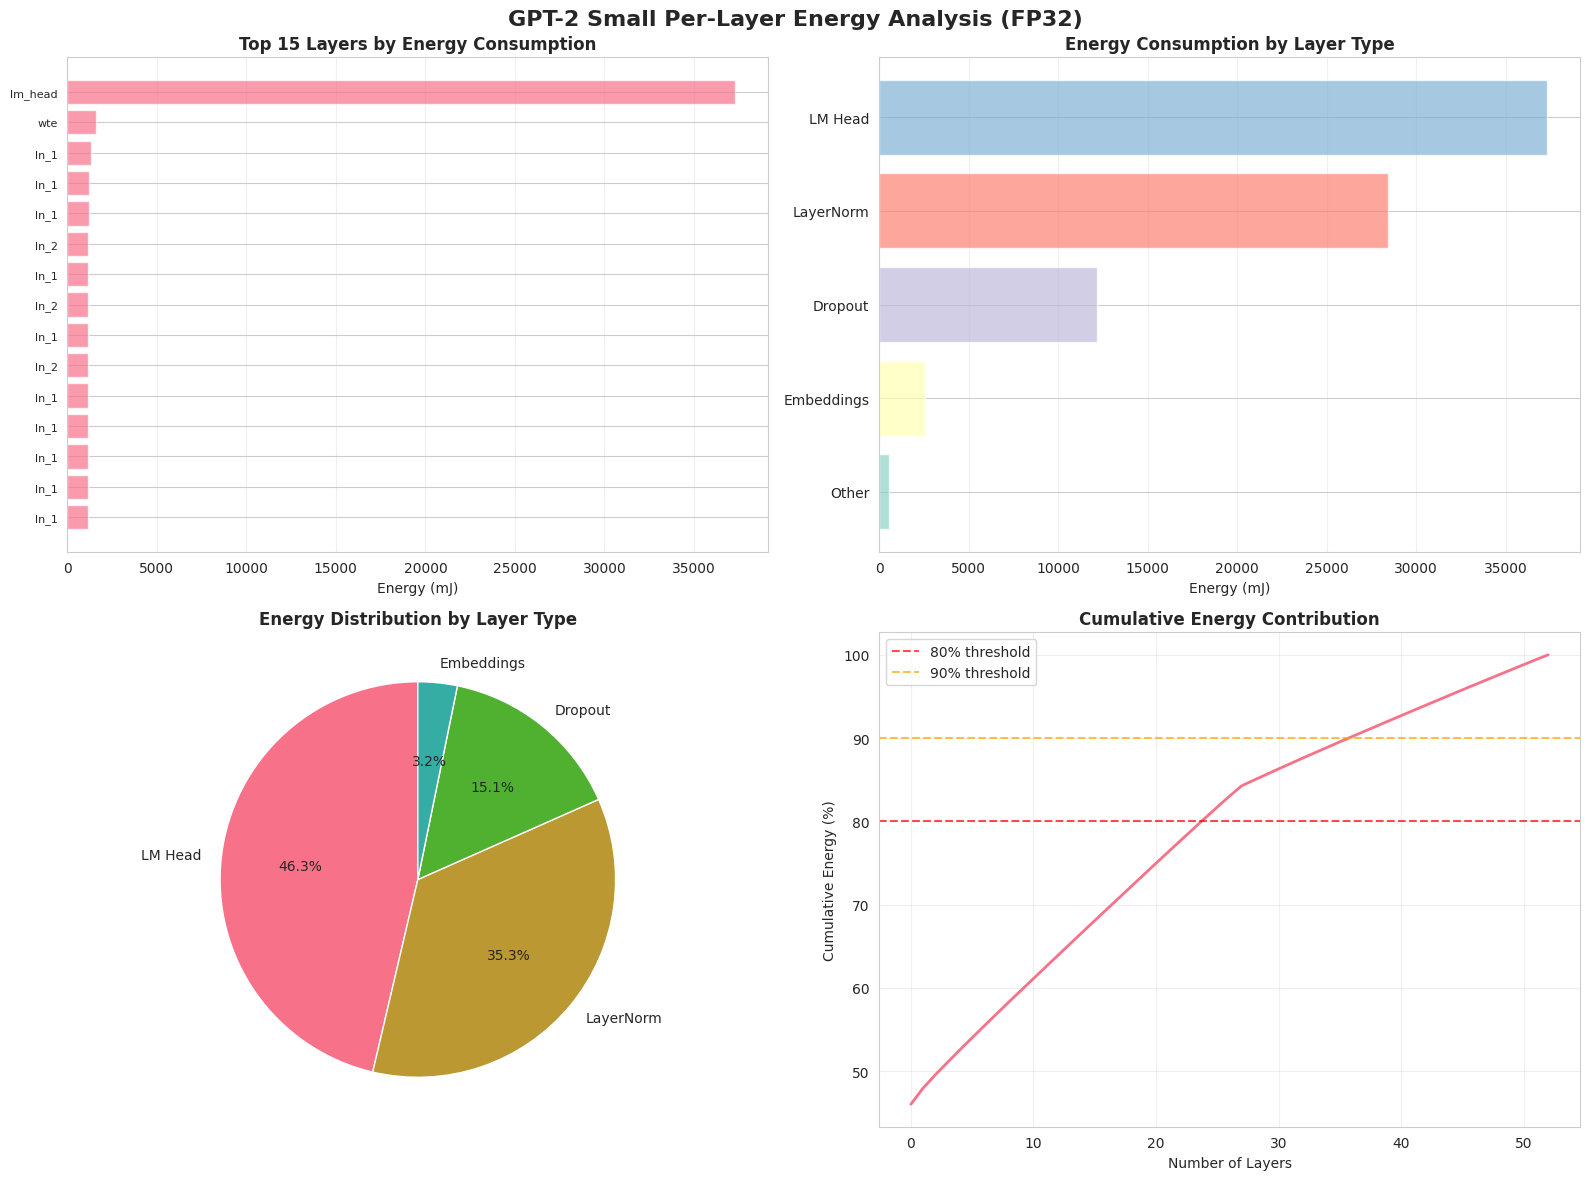

In [12]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("GPT-2 Small Per-Layer Energy Analysis (FP32)", fontsize=16, fontweight='bold')

# 1. Top 15 layers by energy
ax = axes[0, 0]
top_layers = layer_stats.head(15)
y_pos = range(len(top_layers))
ax.barh(y_pos, top_layers["energy_mj"], alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels([name.split('.')[-1] if len(name.split('.')) > 1 else name for name in top_layers["layer_name"]], fontsize=8)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Top 15 Layers by Energy Consumption", fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# 2. Energy by layer type
ax = axes[0, 1]
type_energy_sorted = type_energy.sort_values("energy_mj", ascending=True)
y_pos = range(len(type_energy_sorted))
colors = plt.cm.Set3(range(len(type_energy_sorted)))
ax.barh(y_pos, type_energy_sorted["energy_mj"], alpha=0.7, color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(type_energy_sorted.index, fontsize=10)
ax.set_xlabel("Energy (mJ)", fontsize=10)
ax.set_title("Energy Consumption by Layer Type", fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# 3. Pie chart of energy distribution
ax = axes[1, 0]
type_energy_pie = type_energy[type_energy["percent_energy"] > 1.0]  # Show only >1%
ax.pie(type_energy_pie["percent_energy"], labels=type_energy_pie.index, autopct='%1.1f%%', startangle=90)
ax.set_title("Energy Distribution by Layer Type", fontsize=12, fontweight='bold')

# 4. Cumulative energy contribution
ax = axes[1, 1]
cumulative = layer_stats["energy_mj"].cumsum() / layer_stats["energy_mj"].sum() * 100
ax.plot(range(len(cumulative)), cumulative, linewidth=2)
ax.axhline(y=80, color='r', linestyle='--', alpha=0.7, label='80% threshold')
ax.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax.set_xlabel("Number of Layers", fontsize=10)
ax.set_ylabel("Cumulative Energy (%)", fontsize=10)
ax.set_title("Cumulative Energy Contribution", fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plot_path = output_dir / "per_layer_energy_analysis_gpt2_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"\n✓ Saved plots to: {plot_path}")
plt.show()

## 12. Key Insights

In [13]:
# Find how many layers account for 80% of energy
cumulative_energy = layer_stats["energy_j"].cumsum() / layer_stats["energy_j"].sum()
layers_for_80_pct = (cumulative_energy <= 0.80).sum()
layers_for_90_pct = (cumulative_energy <= 0.90).sum()

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n📊 Energy Distribution:")
print(f"  - Total layers profiled: {len(layer_stats)}")
print(f"  - Layers accounting for 80% of energy: {layers_for_80_pct} ({layers_for_80_pct/len(layer_stats)*100:.1f}%)")
print(f"  - Layers accounting for 90% of energy: {layers_for_90_pct} ({layers_for_90_pct/len(layer_stats)*100:.1f}%)")

print(f"\n🔥 Top Energy Consumers:")
top_3 = layer_stats.head(3)
for i, row in top_3.iterrows():
    print(f"  {row['layer_name']}:")
    print(f"    - Energy: {row['energy_mj']:.2f} mJ ({row['percent_total']:.1f}% of total)")
    print(f"    - Avg time: {row['mean_time_ms']:.3f} ms per call")

print(f"\n🎯 Quantization Strategy Recommendations:")
print(f"  1. Prioritize quantizing: {type_energy.head(3).index.tolist()}")
print(f"  2. These layer types account for {type_energy.head(3)['percent_energy'].sum():.1f}% of total energy")
print(f"  3. Consider keeping embeddings and LayerNorm in higher precision")

print("\n" + "="*80)

# Clean up
profiler.remove_hooks()
print("\n✓ Profiling complete and hooks removed")


KEY INSIGHTS

📊 Energy Distribution:
  - Total layers profiled: 53
  - Layers accounting for 80% of energy: 24 (45.3%)
  - Layers accounting for 90% of energy: 36 (67.9%)

🔥 Top Energy Consumers:
  lm_head:
    - Energy: 37291.71 mJ (46.0% of total)
    - Avg time: 1.723 ms per call
  transformer.wte:
    - Energy: 1577.35 mJ (1.9% of total)
    - Avg time: 0.073 ms per call
  transformer.h.0.ln_1:
    - Energy: 1297.45 mJ (1.6% of total)
    - Avg time: 0.060 ms per call

🎯 Quantization Strategy Recommendations:
  1. Prioritize quantizing: ['LM Head', 'LayerNorm', 'Dropout']
  2. These layer types account for 96.1% of total energy
  3. Consider keeping embeddings and LayerNorm in higher precision


✓ Profiling complete and hooks removed


## 13. Layer Prediction Impact Analysis

Measure how much each layer contributes to model predictions using layer ablation.

**Method**: For each layer, we'll:
1. Get baseline predictions from the full model
2. Ablate the layer (zero out its output) and measure prediction change
3. Compute impact metrics (KL divergence, logit change)

In [14]:
class LayerAblationAnalyzer:
    """
    Analyze prediction impact of each layer by ablating (zeroing out) layers.
    Memory-optimized version for T4 GPU.
    """
    
    def __init__(self, model: nn.Module, device: str = "cuda"):
        self.model = model
        self.device = device
        self.hooks = []
        self.layer_names = []
        
        # Get all leaf modules (actual computation layers)
        for name, module in model.named_modules():
            if len(list(module.children())) == 0:  # Leaf modules only
                if isinstance(module, (nn.Linear, nn.LayerNorm, nn.Dropout, nn.GELU, nn.Embedding, nn.Conv1d)):
                    self.layer_names.append(name)
        
        print(f"✓ Found {len(self.layer_names)} layers for ablation analysis")
    
    def _make_ablation_hook(self, layer_name: str):
        """Create a hook that zeros out the layer output."""
        def ablation_hook(module, input, output):
            # Zero out the output
            if isinstance(output, torch.Tensor):
                return torch.zeros_like(output)
            elif isinstance(output, tuple):
                return tuple(torch.zeros_like(o) if isinstance(o, torch.Tensor) else o for o in output)
            return output
        return ablation_hook
    
    def get_baseline_predictions(self, input_ids, attention_mask, labels=None, num_samples: int = 50):
        """Get baseline predictions from the full model."""
        self.model.eval()
        
        # Clear cache before starting
        if self.device == "cuda":
            torch.cuda.empty_cache()
        
        with torch.no_grad():
            # Use a subset of samples for efficiency
            sample_indices = torch.randperm(input_ids.shape[0])[:num_samples]
            sample_input_ids = input_ids[sample_indices]
            sample_attention_mask = attention_mask[sample_indices]
            sample_labels = labels[sample_indices] if labels is not None else None
            
            outputs = self.model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)
            logits = outputs.logits
            
            # For language modeling, compute perplexity
            if sample_labels is not None:
                loss_fct = nn.CrossEntropyLoss()
                # Shift logits and labels for next token prediction
                shift_logits = logits[..., :-1, :].contiguous()
                shift_labels = sample_labels[..., 1:].contiguous()
                baseline_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)).item()
                baseline_perplexity = np.exp(baseline_loss)
            else:
                baseline_loss = None
                baseline_perplexity = None
            
            # CRITICAL: Move to CPU immediately to free GPU memory
            return {
                'logits': logits.cpu(),
                'probs': torch.softmax(logits.cpu(), dim=-1),  # Compute on CPU
                'loss': baseline_loss,
                'perplexity': baseline_perplexity,
                'indices': sample_indices.cpu()
            }
    
    def measure_layer_impact(self, input_ids, attention_mask, layer_name: str, baseline: dict, labels=None):
        """
        Measure prediction impact of ablating a specific layer.
        
        Returns:
            Dictionary with impact metrics
        """
        self.model.eval()
        
        # Clear cache before each layer
        if self.device == "cuda":
            torch.cuda.empty_cache()
        
        # Register ablation hook
        module = dict(self.model.named_modules())[layer_name]
        hook = module.register_forward_hook(self._make_ablation_hook(layer_name))
        self.hooks.append(hook)
        
        try:
            with torch.no_grad():
                sample_input_ids = input_ids[baseline['indices']]
                sample_attention_mask = attention_mask[baseline['indices']]
                sample_labels = labels[baseline['indices']] if labels is not None else None
                
                outputs = self.model(input_ids=sample_input_ids, attention_mask=sample_attention_mask)
                ablated_logits = outputs.logits.cpu()  # Move to CPU immediately
                ablated_probs = torch.softmax(ablated_logits, dim=-1)  # Compute on CPU
            
            # CRITICAL: All computations on CPU to save GPU memory
            baseline_logits = baseline['logits']  # Already on CPU
            baseline_probs = baseline['probs']    # Already on CPU
            
            # 1. KL Divergence (higher = more impact)
            kl_div = torch.nn.functional.kl_div(
                torch.log(ablated_probs + 1e-8),
                baseline_probs,
                reduction='batchmean'
            ).item()
            
            # 2. L2 distance in logit space
            logit_l2 = torch.nn.functional.mse_loss(
                ablated_logits,
                baseline_logits
            ).item()
            
            # 3. Perplexity change
            if sample_labels is not None and baseline['loss'] is not None:
                loss_fct = nn.CrossEntropyLoss()
                shift_logits = ablated_logits[..., :-1, :].contiguous()
                shift_labels = sample_labels.cpu()[..., 1:].contiguous()
                ablated_loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)).item()
                ablated_perplexity = np.exp(ablated_loss)
                perplexity_change = ablated_perplexity - baseline['perplexity']
            else:
                perplexity_change = None
            
            # 4. Max logit change
            max_logit_change = torch.abs(ablated_logits - baseline_logits).max().item()
            
            # 5. Mean absolute logit change
            mean_logit_change = torch.abs(ablated_logits - baseline_logits).mean().item()
            
            return {
                'kl_divergence': kl_div,
                'logit_l2': logit_l2,
                'perplexity_change': perplexity_change,
                'max_logit_change': max_logit_change,
                'mean_logit_change': mean_logit_change,
                'impact_score': kl_div + logit_l2  # Combined impact score
            }
        finally:
            # Remove hook
            hook.remove()
            if hook in self.hooks:
                self.hooks.remove(hook)
            
            # Clear cache after each layer
            if self.device == "cuda":
                torch.cuda.empty_cache()
    
    def analyze_all_layers(self, input_ids, attention_mask, labels=None, num_samples: int = 50):
        """
        Analyze impact of ablating each layer.
        
        Returns:
            DataFrame with impact metrics for each layer
        """
        print(f"\n📊 Computing baseline predictions ({num_samples} samples)...")
        baseline = self.get_baseline_predictions(input_ids, attention_mask, labels, num_samples)
        if baseline['perplexity'] is not None:
            print(f"✓ Baseline perplexity: {baseline['perplexity']:.2f}")
        else:
            print(f"✓ Baseline computed")
        
        print(f"\n🔬 Analyzing {len(self.layer_names)} layers...")
        results = []
        
        for i, layer_name in enumerate(self.layer_names):
            if (i + 1) % 10 == 0:
                print(f"  Progress: {i+1}/{len(self.layer_names)}", end='\r')
            
            impact = self.measure_layer_impact(input_ids, attention_mask, layer_name, baseline, labels)
            impact['layer_name'] = layer_name
            results.append(impact)
        
        print(f"\n✓ Analysis complete")
        
        df = pd.DataFrame(results)
        df = df.sort_values('impact_score', ascending=False)
        
        return df


# Create analyzer
print("\nInitializing Layer Ablation Analyzer...")
analyzer = LayerAblationAnalyzer(model, device=device)


Initializing Layer Ablation Analyzer...
✓ Found 65 layers for ablation analysis


## 14. Run Prediction Impact Analysis

In [15]:
# Run ablation analysis
# Use only 50 samples to avoid OOM on T4 GPU (reduced from 100)
impact_df = analyzer.analyze_all_layers(input_ids, attention_mask, labels=labels, num_samples=50)

print("\n" + "="*100)
print("PREDICTION IMPACT ANALYSIS (Top 20 Layers)")
print("="*100)
print(impact_df.head(20).to_string(index=False))
print("="*100)

# Save to CSV
impact_df.to_csv(output_dir / "per_layer_prediction_impact_gpt2_fp32.csv", index=False)
print(f"\n✓ Saved prediction impact to: {output_dir / 'per_layer_prediction_impact_gpt2_fp32.csv'}")


📊 Computing baseline predictions (50 samples)...
✓ Baseline perplexity: 181.05

🔬 Analyzing 65 layers...
  Progress: 60/65
✓ Analysis complete

PREDICTION IMPACT ANALYSIS (Top 20 Layers)
 kl_divergence     logit_l2  perplexity_change  max_logit_change  mean_logit_change  impact_score                          layer_name
    809.943909 12462.084961       5.007601e+04        300.475739         107.329170  13272.028870                             lm_head
    809.943909 12462.084961       5.007601e+04        300.475739         107.329170  13272.028870                    transformer.ln_f
    359.300690  8758.868164       5.731772e+03        419.842560          74.430038   9118.168854                transformer.h.1.ln_2
    370.671326  6012.013184       1.183812e+03        265.733612          71.873184   6382.684509                transformer.h.2.ln_2
    751.414856  4522.060059       1.392439e+04        326.461182          55.068436   5273.474915                     transformer.wpe
   1372.

## 15. Merge Energy and Prediction Impact Data

Combine energy consumption and prediction impact data for ALL LAYERS.

In [16]:
# Add layer type to impact dataframe
impact_df["layer_type"] = impact_df["layer_name"].apply(get_layer_type)

# Merge energy and impact data
merged_df = layer_stats[["layer_name", "energy_j", "energy_mj", "mean_time_ms", "layer_type"]].merge(
    impact_df[["layer_name", "kl_divergence", "logit_l2", "perplexity_change", "max_logit_change", "mean_logit_change", "impact_score"]],
    on="layer_name",
    how="inner"
)

print(f"\n" + "="*100)
print(f"MERGED DATA: ENERGY + PREDICTION IMPACT")
print(f"="*100)
print(f"\n✓ Total layers analyzed: {len(merged_df)}")
print(f"\n📊 Layer count by type:")
type_counts = merged_df["layer_type"].value_counts()
for layer_type, count in type_counts.items():
    print(f"  - {layer_type}: {count}")

print(f"\n\nFirst 10 rows:")
print(merged_df.head(10).to_string(index=False))
print("="*100)

# Save merged data
merged_df.to_csv(output_dir / "energy_and_impact_merged_gpt2_fp32.csv", index=False)
print(f"\n✓ Saved merged data to: {output_dir / 'energy_and_impact_merged_gpt2_fp32.csv'}")


MERGED DATA: ENERGY + PREDICTION IMPACT

✓ Total layers analyzed: 53

📊 Layer count by type:
  - LayerNorm: 25
  - Dropout: 24
  - Embeddings: 2
  - LM Head: 1
  - Other: 1


First 10 rows:
           layer_name  energy_j    energy_mj  mean_time_ms layer_type  kl_divergence     logit_l2  perplexity_change  max_logit_change  mean_logit_change  impact_score
              lm_head 37.291709 37291.708938      1.722814    LM Head     809.943909 12462.084961       5.007601e+04        300.475739         107.329170  13272.028870
      transformer.wte  1.577345  1577.345057      0.072871 Embeddings    1372.494995  3845.979004       1.494155e+07        316.332001          51.377701   5218.473999
 transformer.h.0.ln_1  1.297449  1297.449298      0.059940  LayerNorm      43.565205   140.164734       6.749649e+01        235.840042           5.768467    183.729939
 transformer.h.9.ln_1  1.216200  1216.199566      0.056186  LayerNorm       4.130490    26.691032       1.321714e+01        160.495560   

## 16. Correlation Analysis: Energy vs Prediction Impact (ALL LAYERS)

Create a comprehensive correlation matrix showing the relationship between energy consumption and prediction impact for **ALL LAYERS** in GPT-2.

In [17]:
# Prepare data for correlation matrix
# Normalize energy and impact scores for better visualization
merged_df["energy_normalized"] = (merged_df["energy_mj"] - merged_df["energy_mj"].min()) / (merged_df["energy_mj"].max() - merged_df["energy_mj"].min())
merged_df["impact_normalized"] = (merged_df["impact_score"] - merged_df["impact_score"].min()) / (merged_df["impact_score"].max() - merged_df["impact_score"].min())

# Select columns for correlation
corr_columns = [
    "energy_j", "energy_mj", "mean_time_ms",
    "kl_divergence", "logit_l2", "max_logit_change", "mean_logit_change", "impact_score",
    "energy_normalized", "impact_normalized"
]

# Compute correlation matrix
corr_matrix = merged_df[corr_columns].corr()

print("\n" + "="*100)
print(f"CORRELATION MATRIX: Energy Consumption vs Prediction Impact (ALL {len(merged_df)} LAYERS)")
print("="*100)
print(corr_matrix.to_string())
print("="*100)

# Key correlations
print(f"\n📊 Key Correlations:")
print(f"  Energy (mJ) vs Impact Score:      {corr_matrix.loc['energy_mj', 'impact_score']:.4f}")
print(f"  Energy (mJ) vs KL Divergence:     {corr_matrix.loc['energy_mj', 'kl_divergence']:.4f}")
print(f"  Energy (mJ) vs Logit L2:          {corr_matrix.loc['energy_mj', 'logit_l2']:.4f}")
print(f"  Energy (mJ) vs Max Logit Change:  {corr_matrix.loc['energy_mj', 'max_logit_change']:.4f}")
print(f"  Energy (mJ) vs Mean Logit Change: {corr_matrix.loc['energy_mj', 'mean_logit_change']:.4f}")

# Interpretation
overall_corr = corr_matrix.loc['energy_mj', 'impact_score']
if overall_corr > 0.3:
    interpretation = "✓ Positive correlation: Energy-hungry layers tend to have higher prediction impact"
elif overall_corr < -0.3:
    interpretation = "⚠️  Negative correlation: Energy-hungry layers tend to have lower prediction impact"
else:
    interpretation = "➖ Weak correlation: No strong relationship between energy and prediction impact"

print(f"\n💡 Interpretation: {interpretation}")

# Save correlation matrix
corr_matrix.to_csv(output_dir / "energy_impact_correlation_matrix_gpt2_fp32.csv")
print(f"\n✓ Saved correlation matrix to: {output_dir / 'energy_impact_correlation_matrix_gpt2_fp32.csv'}")


CORRELATION MATRIX: Energy Consumption vs Prediction Impact (ALL 53 LAYERS)
                   energy_j  energy_mj  mean_time_ms  kl_divergence  logit_l2  max_logit_change  mean_logit_change  impact_score  energy_normalized  impact_normalized
energy_j           1.000000   1.000000      1.000000       0.291440  0.580786          0.105280           0.523093      0.570221           1.000000           0.570221
energy_mj          1.000000   1.000000      1.000000       0.291440  0.580786          0.105280           0.523093      0.570221           1.000000           0.570221
mean_time_ms       1.000000   1.000000      1.000000       0.291440  0.580786          0.105280           0.523093      0.570221           1.000000           0.570221
kl_divergence      0.291440   0.291440      0.291440       1.000000  0.632136          0.363954           0.714230      0.696490           0.291440           0.696490
logit_l2           0.580786   0.580786      0.580786       0.632136  1.000000          0

## 17. Visualize Correlation Matrix Heatmap

✓ Saved correlation heatmap to: ../results/energy_impact_correlation_heatmap_gpt2_fp32.png


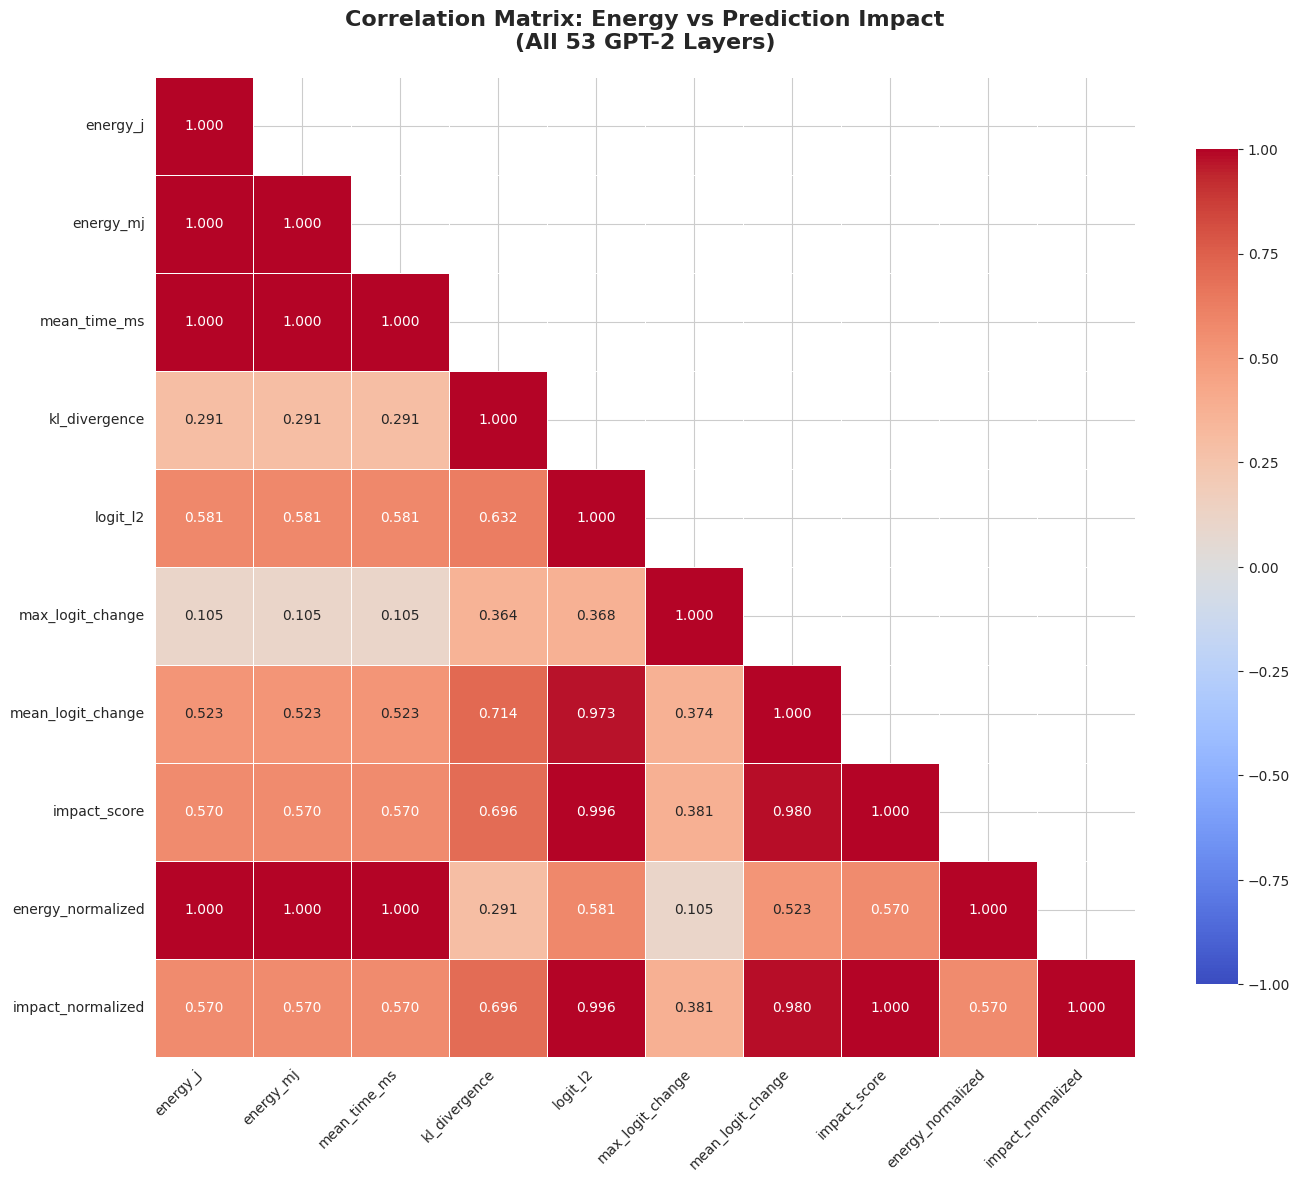

In [18]:
# Create correlation heatmap
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Create heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # Mask upper triangle
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    mask=mask,
    ax=ax,
    vmin=-1,
    vmax=1
)

ax.set_title(f"Correlation Matrix: Energy vs Prediction Impact\n(All {len(merged_df)} GPT-2 Layers)", 
             fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plot_path = output_dir / "energy_impact_correlation_heatmap_gpt2_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved correlation heatmap to: {plot_path}")
plt.show()

## 18. Scatter Plot: Energy vs Prediction Impact (All Layers)

✓ Saved scatter plot to: ../results/energy_vs_impact_scatter_gpt2_fp32.png


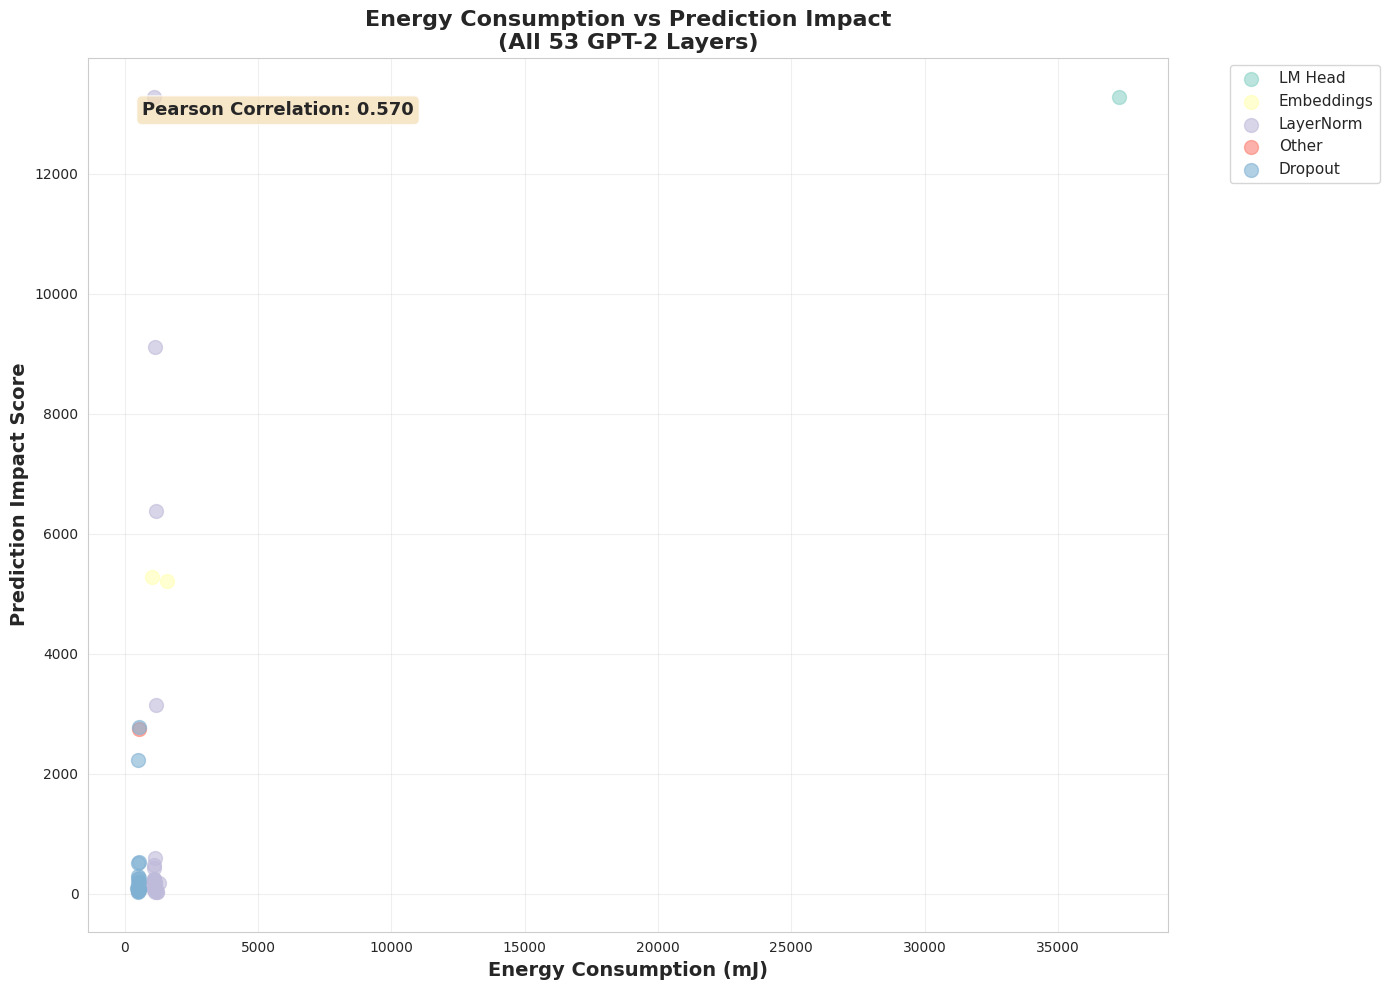

In [19]:
# Create scatter plot: Energy vs Impact
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Color by layer type
layer_types = merged_df["layer_type"].unique()
colors_map = dict(zip(layer_types, plt.cm.Set3(range(len(layer_types)))))

for layer_type in layer_types:
    mask = merged_df["layer_type"] == layer_type
    ax.scatter(
        merged_df.loc[mask, "energy_mj"],
        merged_df.loc[mask, "impact_score"],
        label=layer_type,
        alpha=0.6,
        s=100,
        color=colors_map[layer_type]
    )

ax.set_xlabel("Energy Consumption (mJ)", fontsize=14, fontweight='bold')
ax.set_ylabel("Prediction Impact Score", fontsize=14, fontweight='bold')
ax.set_title(f"Energy Consumption vs Prediction Impact\n(All {len(merged_df)} GPT-2 Layers)", 
             fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.grid(alpha=0.3)

# Add correlation coefficient
corr_coef = merged_df["energy_mj"].corr(merged_df["impact_score"])
ax.text(0.05, 0.95, f'Pearson Correlation: {corr_coef:.3f}', 
        transform=ax.transAxes, fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7),
        verticalalignment='top')

plt.tight_layout()
plot_path = output_dir / "energy_vs_impact_scatter_gpt2_fp32.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✓ Saved scatter plot to: {plot_path}")
plt.show()

## 19. Summary: Quantization Strategy Based on Energy-Impact Analysis

In [20]:
print("\n" + "="*100)
print(f"FINAL SUMMARY: QUANTIZATION STRATEGY FOR GPT-2 ({len(merged_df)} LAYERS ANALYZED)")
print("="*100)

# Overall statistics
print(f"\n📊 Overall Statistics:")
print(f"  Total layers profiled:        {len(merged_df)}")
print(f"  Total energy (all layers):    {merged_df['energy_j'].sum():.2f} J")
print(f"  Mean energy per layer:        {merged_df['energy_mj'].mean():.2f} mJ")
print(f"  Mean impact score per layer:  {merged_df['impact_score'].mean():.4f}")

# Correlation
overall_corr = merged_df["energy_mj"].corr(merged_df["impact_score"])
print(f"\n🔗 Energy-Impact Correlation:")
print(f"  Pearson correlation coefficient: {overall_corr:.4f}")

if overall_corr > 0.3:
    corr_interpretation = "Strong positive: High-energy layers contribute more to predictions"
elif overall_corr > 0.1:
    corr_interpretation = "Moderate positive: Some correlation between energy and prediction impact"
elif overall_corr > -0.1:
    corr_interpretation = "Weak/No correlation: Energy and prediction impact are independent"
else:
    corr_interpretation = "Negative: High-energy layers contribute less to predictions (ideal for quantization!)"

print(f"  Interpretation: {corr_interpretation}")

# Find layers with high energy but low impact (best quantization candidates)
merged_df["energy_rank"] = merged_df["energy_mj"].rank(ascending=False)
merged_df["impact_rank"] = merged_df["impact_score"].rank(ascending=False)
merged_df["rank_diff"] = merged_df["energy_rank"] - merged_df["impact_rank"]  # Positive = high energy, low impact

print(f"\n💡 BEST QUANTIZATION CANDIDATES (High Energy, Low Impact):")
print(f"   (Layers that consume energy but don't contribute much to predictions)")
print("="*100)

high_energy_low_impact = merged_df.nlargest(10, "rank_diff")[
    ["layer_name", "energy_mj", "impact_score", "energy_rank", "impact_rank", "rank_diff", "layer_type"]
]

for idx, row in high_energy_low_impact.iterrows():
    print(f"\n  {row['layer_name']}")
    print(f"    Energy:  {row['energy_mj']:.2f} mJ (rank #{int(row['energy_rank'])})")
    print(f"    Impact:  {row['impact_score']:.4f} (rank #{int(row['impact_rank'])})")
    print(f"    Rank difference: {int(row['rank_diff'])} (higher = better candidate)")
    print(f"    Type: {row['layer_type']}")

print("\n" + "="*100)
print(f"⚠️  LAYERS TO KEEP IN HIGH PRECISION (High Impact):")
print(f"   (Layers critical for model predictions)")
print("="*100)

high_impact_layers = merged_df.nlargest(5, "impact_score")[
    ["layer_name", "energy_mj", "impact_score", "layer_type"]
]

for idx, row in high_impact_layers.iterrows():
    print(f"\n  {row['layer_name']}")
    print(f"    Impact:  {row['impact_score']:.4f}")
    print(f"    Energy:  {row['energy_mj']:.2f} mJ")
    print(f"    Type: {row['layer_type']}")

# Save rankings
merged_df.to_csv(output_dir / "quantization_candidates_ranked_gpt2_fp32.csv", index=False)
print(f"\n\n✓ Saved ranked quantization candidates to: {output_dir / 'quantization_candidates_ranked_gpt2_fp32.csv'}")

print("\n" + "="*100)
print("✓ ANALYSIS COMPLETE")
print("="*100)


FINAL SUMMARY: QUANTIZATION STRATEGY FOR GPT-2 (53 LAYERS ANALYZED)

📊 Overall Statistics:
  Total layers profiled:        53
  Total energy (all layers):    81.03 J
  Mean energy per layer:        1528.80 mJ
  Mean impact score per layer:  1333.1169

🔗 Energy-Impact Correlation:
  Pearson correlation coefficient: 0.5702
  Interpretation: Strong positive: High-energy layers contribute more to predictions

💡 BEST QUANTIZATION CANDIDATES (High Energy, Low Impact):
   (Layers that consume energy but don't contribute much to predictions)

  transformer.h.0.attn.resid_dropout
    Energy:  510.11 mJ (rank #39)
    Impact:  2225.3674 (rank #10)
    Rank difference: 29 (higher = better candidate)
    Type: Dropout

  transformer.h.11.mlp.dropout
    Energy:  501.19 mJ (rank #44)
    Impact:  302.3518 (rank #16)
    Rank difference: 28 (higher = better candidate)
    Type: Dropout

  transformer.h.11.attn.resid_dropout
    Energy:  508.05 mJ (rank #40)
    Impact:  516.5239 (rank #13)
    Rank